In [107]:
### Basic Imports
import pandas as pd
import numpy as np

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 


### Importing the relevant ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score,roc_curve,auc,recall_score,f1_score,precision_score,classification_report,confusion_matrix,auc

### Some cosmetics add-ons
plt.style.use('fivethirtyeight')
%matplotlib inline

# Loading dataset

In [108]:
s2014 = pd.read_csv('annual_data/nba_season_2014_data.csv')
s2015 = pd.read_csv('annual_data/nba_season_2015_data.csv')
s2016 = pd.read_csv('annual_data/nba_season_2016_data.csv')
s2017 = pd.read_csv('annual_data/nba_season_2017_data.csv')
s2018 = pd.read_csv('annual_data/nba_season_2018_data.csv')
s2019 = pd.read_csv('annual_data/nba_season_2019_data.csv')


In [109]:
s2014.info(verbose=True , null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 111 columns):
SEASON_ID_x            1230 non-null int64
TEAM_ID_x              1230 non-null int64
TEAM_ABBREVIATION_x    1230 non-null object
TEAM_NAME_x            1230 non-null object
GAME_ID                1230 non-null int64
GAME_DATE_x            1230 non-null object
MATCHUP_x              1230 non-null object
WL_x                   1230 non-null int64
MIN_x                  1230 non-null int64
PTS_x                  1230 non-null int64
FGM_x                  1230 non-null int64
FGA_x                  1230 non-null int64
FG_PCT_x               1230 non-null float64
FG3M_x                 1230 non-null int64
FG3A_x                 1230 non-null float64
FG3_PCT_x              1230 non-null float64
FTM_x                  1230 non-null int64
FTA_x                  1230 non-null int64
FT_PCT_x               1230 non-null float64
OREB_x                 1230 non-null float64
DREB_x            

## Removing rows where either teams are playing their first games (the disparity stats will be off for these games)

In [110]:
for df in (s2014, s2015, s2016, s2017, s2018, s2019):
    df.drop(df[(df.GAME_PLAYED_x == 1) | (df.GAME_PLAYED_y == 1)].index, inplace = True)

# Creating our target and independent variables

In [111]:
features_list = ['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']
target = 'WL_x'

# Plotting distribution graphs for all the variables

In [112]:
# Function to plot distribution graphs

def eda_plots(df,features_list,plot_title,fig_size):

    df[features_list].hist(bins=40,edgecolor='b',linewidth=1.0,xlabelsize=8,ylabelsize=8,grid= False,figsize=fig_size ,color='red')

    plt.tight_layout(rect=(0,0,1.2,1.2))

    # Overall title for all the plots
    plt.suptitle(plot_title,x=0.65,y=1.25,fontsize=14)

    plt.show()

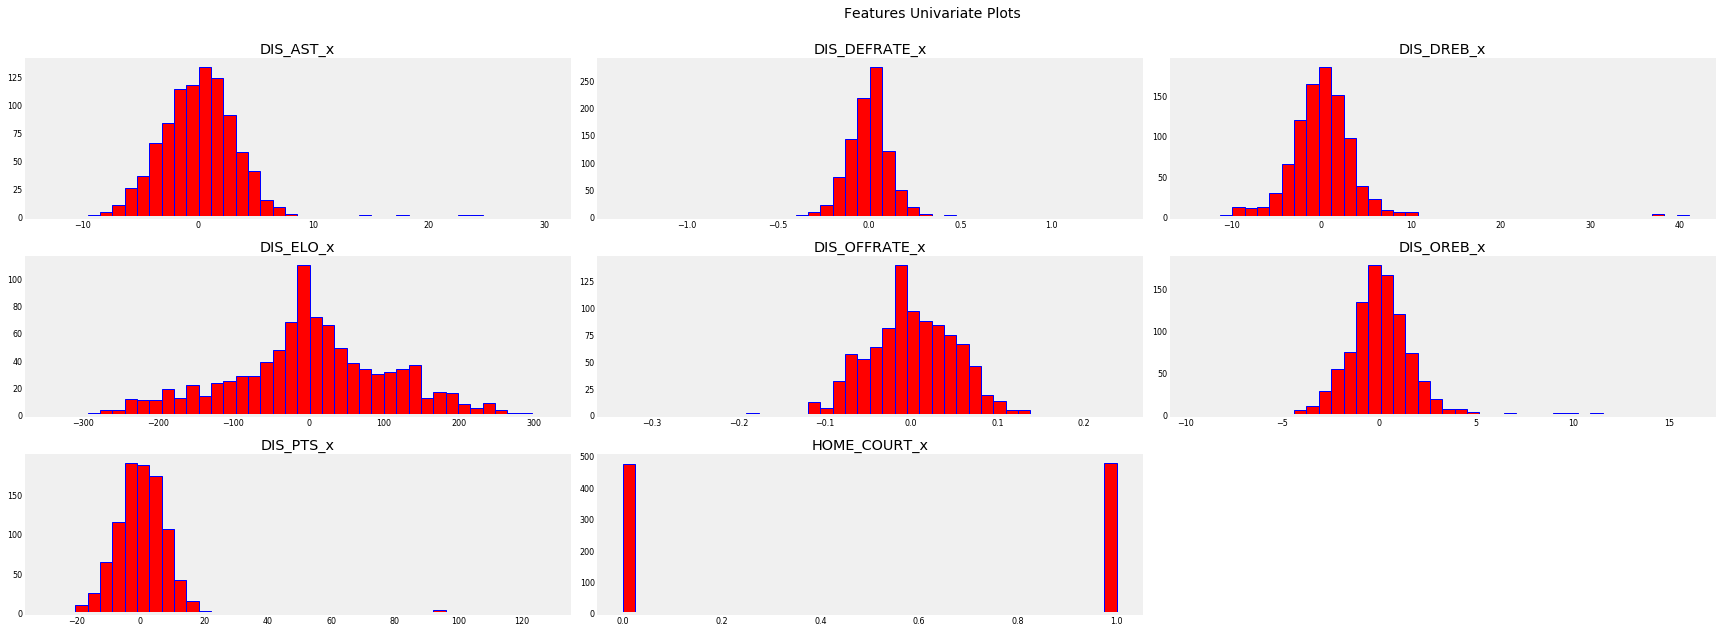

In [113]:
eda_plots(df,features_list,'Features Univariate Plots',(20,7))

All variables are relatively normally distributed. 

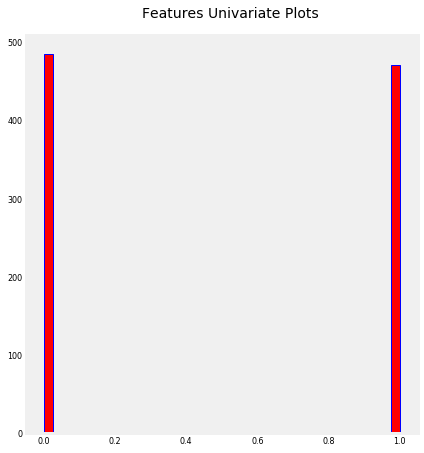

In [114]:
eda_plots(df,target,'Features Univariate Plots',(5,5))

Balanced target variable!

# Training model for each year 

In [115]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False)
}

performance_data = {}

In [116]:
season = 2014
models_acc_per_season = {} # to store all the model acc scores for every season
for df in (s2014, s2015, s2016, s2017, s2018, s2019):

    # Creating our independent and dependent variables df
    x = df[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
    y = df['WL_x']

    # Perform train test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15) 
    # X_train.shape, X_test.shape, y_train.shape, y_test.shape

    model_acc_score = [] # store all the model acc scores for 1 season
    performance_data[season] = {
        'accuracy':[],
        'precision':[],
        'recall':[],
        'f1':[]
    } # store acc, precision, recall, f1 score for each season 

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]
        
        m.fit(X_train, y_train)
        predictions = m.predict(X_test)

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
        model_acc_score.append((model_name, acc))

        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        # adding into the performance data dict
        performance_data[season]['accuracy'].append(acc)
        performance_data[season]['precision'].append(precision)
        performance_data[season]['recall'].append(recall)
        performance_data[season]['f1'].append(f1)

        print('Accuracy Score for {} is {:.5f} in season {}'.format(model_name,acc,season))
    
    models_acc_per_season[season] = model_acc_score # add current season models' acc into the dict
    
    print('-'*60)
    print()
    season += 1
    

Accuracy Score for Logistic Regression is 0.65659 in season 2014
Accuracy Score for Naive Bayes is 0.67582 in season 2014
Accuracy Score for Decision Trees is 0.57418 in season 2014
Accuracy Score for SVM linear is 0.67308 in season 2014
Accuracy Score for SVM rbf is 0.53571 in season 2014
Accuracy Score for Random Forest is 0.65385 in season 2014
[17:07:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score for XGBoost is 0.65110 in season 2014
------------------------------------------------------------

Accuracy Score for Logistic Regression is 0.66209 in season 2015
Accuracy Score for Naive Bayes is 0.63736 in season 2015
Accuracy Score for Decision Trees is 0.58516 in season 2015
Accuracy Score for SVM linear is 0.66484 in season 2015
Accuracy Score 

## Retrieving best model for each year

In [117]:
for k, v in models_acc_per_season.items():
    v.sort(key=lambda x: x[1], reverse = True)
    models_acc_per_season[k] = v
    print(f'Best model in {k} is {v[0]}')

Best model in 2014 is ('Naive Bayes', 0.6758241758241759)
Best model in 2015 is ('SVM linear', 0.6648351648351648)
Best model in 2016 is ('SVM linear', 0.6191780821917808)
Best model in 2017 is ('Naive Bayes', 0.5945205479452055)
Best model in 2018 is ('SVM linear', 0.6684931506849315)
Best model in 2019 is ('Logistic Regression', 0.6794425087108014)


# Performance Analysis

In [118]:
season = 2014
for k, v in performance_data.items():
    print(season)
    print('-'*60)
    performance_df = pd.DataFrame(v,index=list(models_dict.keys()))
    print(performance_df)
    print()
    season+=1

2014
------------------------------------------------------------
                     accuracy  precision    recall        f1
Logistic Regression  0.656593   0.695876  0.671642  0.683544
Naive Bayes          0.675824   0.686099  0.761194  0.721698
Decision Trees       0.574176   0.605505  0.656716  0.630072
SVM linear           0.673077   0.700980  0.711443  0.706173
SVM rbf              0.535714   0.621212  0.407960  0.492492
Random Forest        0.653846   0.690355  0.676617  0.683417
XGBoost              0.651099   0.679612  0.696517  0.687961

2015
------------------------------------------------------------
                     accuracy  precision    recall        f1
Logistic Regression  0.662088   0.677249  0.673684  0.675462
Naive Bayes          0.637363   0.790000  0.415789  0.544828
Decision Trees       0.585165   0.603175  0.600000  0.601583
SVM linear           0.664835   0.680851  0.673684  0.677249
SVM rbf              0.560440   0.560976  0.726316  0.633028
Random Forest

# Predict using every model

In [119]:
season_df = s2014 # change this to the season df you want to print out the confusion matrix for that season

for model_name in models_dict:
    x = season_df[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
    y = season_df['WL_x']

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15) 

    m = models_dict[model_name]
    prediction = m.predict(X_test)

    print('*'*60)
    print(f'Classification Report ({model_name}): \n')
    print(classification_report(y_test,prediction)) 

    print('-'*60)
    print('Confusion Matrix: \n')

    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm,columns=[0,1],index=[0,1]) 
    # should it be columns=[1,0] instead? win = 1, lose = 0. 

    print('Predicted')
    print(cm_df,'Acutal')
    print('*'*60)
    print()
    print()

************************************************************
Classification Report (Logistic Regression): 

              precision    recall  f1-score   support

           0       0.58      0.66      0.62       163
           1       0.69      0.62      0.65       201

    accuracy                           0.63       364
   macro avg       0.64      0.64      0.63       364
weighted avg       0.64      0.63      0.64       364

------------------------------------------------------------
Confusion Matrix: 

Predicted
     0    1
0  107   56
1   77  124 Acutal
************************************************************


************************************************************
Classification Report (Naive Bayes): 

              precision    recall  f1-score   support

           0       0.66      0.58      0.62       163
           1       0.69      0.75      0.72       201

    accuracy                           0.68       364
   macro avg       0.67      0.67      0.67       

# Changing our X variables to see if we can yield better accuracy in our models

In [120]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False)
}

performance_data_2 = {}
performance_data_3 = {}

In [121]:
season = 2014
models_acc_per_season_2 = {} # to store all the model acc scores for every season
for df in (s2014, s2015, s2016, s2017, s2018, s2019):

    # Creating our independent and dependent variables df
    x = df[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x']] # 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x'
    y = df['WL_x']

    # Perform train test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15) 
    # X_train.shape, X_test.shape, y_train.shape, y_test.shape

    model_acc_score = [] # store all the model acc scores for 1 season
    performance_data_2[season] = {
        'accuracy':[],
        'precision':[],
        'recall':[],
        'f1':[]
    } # store acc, precision, recall, f1 score for each season 

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]
        
        m.fit(X_train, y_train)
        predictions = m.predict(X_test)

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
        model_acc_score.append((model_name, acc))

        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        # adding into the performance data dict
        performance_data_2[season]['accuracy'].append(acc)
        performance_data_2[season]['precision'].append(precision)
        performance_data_2[season]['recall'].append(recall)
        performance_data_2[season]['f1'].append(f1)

        print('Accuracy Score for {} is {:.5f} in season {}'.format(model_name,acc,season))
    
    models_acc_per_season_2[season] = model_acc_score # add current season models' acc into the dict
    
    print('-'*60)
    print()
    season += 1

Accuracy Score for Logistic Regression is 0.66484 in season 2014
Accuracy Score for Naive Bayes is 0.68681 in season 2014
Accuracy Score for Decision Trees is 0.58791 in season 2014
Accuracy Score for SVM linear is 0.66484 in season 2014
Accuracy Score for SVM rbf is 0.64835 in season 2014
Accuracy Score for Random Forest is 0.62088 in season 2014
[17:08:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score for XGBoost is 0.60440 in season 2014
------------------------------------------------------------

Accuracy Score for Logistic Regression is 0.65385 in season 2015
Accuracy Score for Naive Bayes is 0.67857 in season 2015
Accuracy Score for Decision Trees is 0.58242 in season 2015
Accuracy Score for SVM linear is 0.67308 in season 2015
Accuracy Score 

In [122]:
for k, v in models_acc_per_season_2.items():
    v.sort(key=lambda x: x[1], reverse = True)
    models_acc_per_season_2[k] = v
    print(f'Best model in {k} is {v[0]}')

print()
for k, v in models_acc_per_season.items():
    v.sort(key=lambda x: x[1], reverse = True)
    models_acc_per_season[k] = v
    print(f'Best model in {k} is {v[0]}')

Best model in 2014 is ('Naive Bayes', 0.6868131868131868)
Best model in 2015 is ('Naive Bayes', 0.6785714285714286)
Best model in 2016 is ('Naive Bayes', 0.6164383561643836)
Best model in 2017 is ('Logistic Regression', 0.6109589041095891)
Best model in 2018 is ('Logistic Regression', 0.6712328767123288)
Best model in 2019 is ('Logistic Regression', 0.6898954703832753)

Best model in 2014 is ('Naive Bayes', 0.6758241758241759)
Best model in 2015 is ('SVM linear', 0.6648351648351648)
Best model in 2016 is ('SVM linear', 0.6191780821917808)
Best model in 2017 is ('Naive Bayes', 0.5945205479452055)
Best model in 2018 is ('SVM linear', 0.6684931506849315)
Best model in 2019 is ('Logistic Regression', 0.6794425087108014)


# Splitting data into first half season and second half season, instead of 70% training, 30% testing

In [123]:
season_yr_df = s2014 # change this to whichever year you wanna analyze

first_half = season_yr_df[(season_yr_df['GAME_PLAYED_x'] <= 41) | (season_yr_df['GAME_PLAYED_y'] <= 41 )]
second_half = season_yr_df[(season_yr_df['GAME_PLAYED_x'] > 41) & (season_yr_df['GAME_PLAYED_y'] > 41 )]

X_train = first_half[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
X_test = second_half[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
y_train = first_half['WL_x']
y_test = second_half['WL_x']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((607, 8), (606, 8), (607,), (606,))

In [124]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False)
}

performance_data_1 = {
    'accuracy':[],
    'precision':[],
    'recall':[],
    'f1':[]
}

In [125]:
for model_name in models_dict:
    m = models_dict[model_name]
    
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    # adding into the performance data dict
    performance_data_1['accuracy'].append(acc)
    performance_data_1['precision'].append(precision)
    performance_data_1['recall'].append(recall)
    performance_data_1['f1'].append(f1)

    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))

Accuracy Score for Logistic Regression is 0.67162
Accuracy Score for Naive Bayes is 0.67657
Accuracy Score for Decision Trees is 0.53135
Accuracy Score for SVM linear is 0.67327
Accuracy Score for SVM rbf is 0.54785
Accuracy Score for Random Forest is 0.64356
[17:08:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score for XGBoost is 0.61881


In [126]:
performance_df = pd.DataFrame(performance_data_1,index=list(models_dict.keys()))
performance_df

,accuracy,precision,recall,f1
Logistic Regression,0.671617,0.673981,0.693548,0.683625
Naive Bayes,0.676568,0.646154,0.812903,0.720000
Decision Trees,0.531353,0.542763,0.532258,0.537459
SVM linear,0.673267,0.673913,0.700000,0.686709
SVM rbf,0.547855,0.541860,0.751613,0.629730
Random Forest,0.643564,0.642424,0.683871,0.662500
XGBoost,0.618812,0.621538,0.651613,0.636220


In [127]:
for model_name in models_dict:
    m = models_dict[model_name]
    prediction = m.predict(X_test)

    print('*'*60)
    print(f'Classification Report ({model_name}): \n')
    print(classification_report(y_test,prediction)) 

    print('-'*60)
    print('Confusion Matrix: \n')

    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm,columns=[0,1],index=[0,1]) 
    # should it be columns=[1,0] instead? win = 1, lose = 0. 

    print('Predicted')
    print(cm_df,'Acutal')
    print('*'*60)
    print()
    print()

************************************************************
Classification Report (Logistic Regression): 

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       296
           1       0.67      0.69      0.68       310

    accuracy                           0.67       606
   macro avg       0.67      0.67      0.67       606
weighted avg       0.67      0.67      0.67       606

------------------------------------------------------------
Confusion Matrix: 

Predicted
     0    1
0  192  104
1   95  215 Acutal
************************************************************


************************************************************
Classification Report (Naive Bayes): 

              precision    recall  f1-score   support

           0       0.73      0.53      0.62       296
           1       0.65      0.81      0.72       310

    accuracy                           0.68       606
   macro avg       0.69      0.67      0.67       